# Transfer Learning For Binary-Class Image Classification Using Deep Convolutional Neural Network

## Task 7:
> Problem: Transfer learning
> Show use the use of transfer learning to train a model on
> less data (<1000 images) and still getting good results (>80% accuracy) to demonstrate use
> of transfer learning. You are free to pick a model of your choice and dataset of your choice.
> (just don’t pick dataset which is already used in initial training)

**In this notebook I am going to solve above problem, I will implement the binary-class image classification using the VGG-16 Deep Convolutional Network used as a Transfer Learning framework where the VGGNet comes pre-trained on the ImageNet dataset. For the experiment, we will use the Kaggle dogs-vs-cats dataset and classify the image objects into 2 classes. The classification accuracies of the VGG-16 model will be visualized using the confusion matrices.**

## What is Transfer Learning?

**Transfer learning is a research problem in the field of machine learning. It stores the knowledge gained while solving one problem and applies it to a different but related problem. In deep learning, transfer learning is a technique whereby a neural network model is first trained on a problem similar to the problem that is being solved. Transfer learning has the advantage of decreasing the training time for a learning model and can result in lower generalization error.**

## VGGNet – The Deep Convolutional Network

**VGGNet is Deep Convolutional Neural Network that was proposed by Karen Simonyan and Andrew Zisserman of the University of Oxford in their research work ‘Very Deep Convolutional Neural Networks for Large-Scale Image Recognition’. The name of this model was inspired by the name of their research group ‘Visual Geometry Group (VGG)’. As this convolutional neural network has 16 layers in its architecture, it was named VGG-16. This model was proposed to reduce the number of parameters in a convolutional neural network with improved training time.**

**The biggest advantage of this network is that we can load a pre-trained version of the network trained on more than a million images from the ImageNet database. A pre-trained network can classify images into thousands of object categories. Due to this advantage, I am going to apply this model on the Kaggle dogs-vs-cats dataset image dataset that has 2 object categories.**

## The Dataset

To complete this task, I shall be using the Kaggle dogs-vs-cats dataset that is a publically available image data set provided by the Kaggle. It consists of 25000 colour images in 2 classes as a train dataset. I work on only train dataset so i am not going to discuss about test dataset and here i am talking about raw dataset which is actually train dataset as discussed above. I will slice first 1000 (raw_dataset[:1000]) images from the original raw dataset, out of which 503 are dog and 497 are cat. and then split it into validate as 100 and 900 as train. To test our model I have sliced 200 dataset from original raw dataset[10000:10200].

## Importing libraries

In [88]:
import numpy as np
import pandas as pd
import os
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.applications import VGG16
from keras.models import Model
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [89]:
print(os.listdir('../input/dogs-vs-cats-redux-kernels-edition'))

['sample_submission.csv', 'test.zip', 'train.zip']


In [90]:
import zipfile


zip_files = ['test', 'train']
# Will unzip the files
for zip_file in zip_files:
    with zipfile.ZipFile("../input/dogs-vs-cats-redux-kernels-edition/{}.zip".format(zip_file),"r") as z:
        z.extractall(".")
        print("{} unzipped".format(zip_file))

test unzipped
train unzipped


In [91]:
IMAGE_FOLDER_PATH="../working/train"
FILE_NAMES=os.listdir(IMAGE_FOLDER_PATH)
WIDTH=150
HEIGHT=150

In [92]:
targets=list()
full_paths=list()
for file_name in FILE_NAMES:
    target=file_name.split(".")[0]
    full_path=os.path.join(IMAGE_FOLDER_PATH, file_name)
    full_paths.append(full_path)
    targets.append(target)

raw_dataset=pd.DataFrame()
raw_dataset['image_path']=full_paths
raw_dataset['target']=targets

### Dataset 

In [94]:
raw_dataset.shape

(25000, 2)

In [95]:
dataset = raw_dataset[:1000]

In [96]:
dataset['target'].value_counts()

dog    503
cat    497
Name: target, dtype: int64

In [97]:
dataset.head()

,image_path,target
0,../working/train/dog.8126.jpg,dog
1,../working/train/dog.1626.jpg,dog
2,../working/train/dog.2323.jpg,dog
3,../working/train/cat.8652.jpg,cat
4,../working/train/dog.2171.jpg,dog


In [98]:
train_df, validate_df = train_test_split(dataset, test_size=0.1)

In [99]:
train_df["target"].value_counts()

cat    451
dog    449
Name: target, dtype: int64

In [100]:
validate_df["target"].value_counts()

dog    54
cat    46
Name: target, dtype: int64

In [101]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

### Train generator

In [103]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [104]:
image_size = 224
input_shape = (image_size, image_size, 3)

epochs = 5
batch_size = 6

In [105]:
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    #"../input/train/train/", 
    x_col='image_path',
    y_col='target',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 900 validated image filenames belonging to 2 classes.


###  Validation generator

In [107]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    ##"../input/train/train/", 
    x_col='image_path',
    y_col='target',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 100 validated image filenames belonging to 2 classes.


### Defining VGG16 as a Deep Convolutional Neural Network and load it as a pre trained model. 
### Adding the Dense layers along with activation

In [108]:
pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
    
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True
    
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
    
# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

### Now, we start training our VGG16, the deep convolutional neural network model.

In [109]:
Trained_model = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size)

Epoch 1/5
150/150 [==============================] - 16s 105ms/step - loss: 0.6962 - accuracy: 0.6033 - val_loss: 0.4253 - val_accuracy: 0.8438
Epoch 2/5
150/150 [==============================] - 15s 99ms/step - loss: 0.4455 - accuracy: 0.7778 - val_loss: 0.2813 - val_accuracy: 0.8750
Epoch 3/5
150/150 [==============================] - 17s 113ms/step - loss: 0.3136 - accuracy: 0.8422 - val_loss: 0.2508 - val_accuracy: 0.8542
Epoch 4/5
150/150 [==============================] - 14s 97ms/step - loss: 0.2692 - accuracy: 0.8900 - val_loss: 0.1704 - val_accuracy: 0.9271
Epoch 5/5
150/150 [==============================] - 15s 101ms/step - loss: 0.2173 - accuracy: 0.9067 - val_loss: 0.1917 - val_accuracy: 0.9167


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  from ipykernel import kernelapp as app


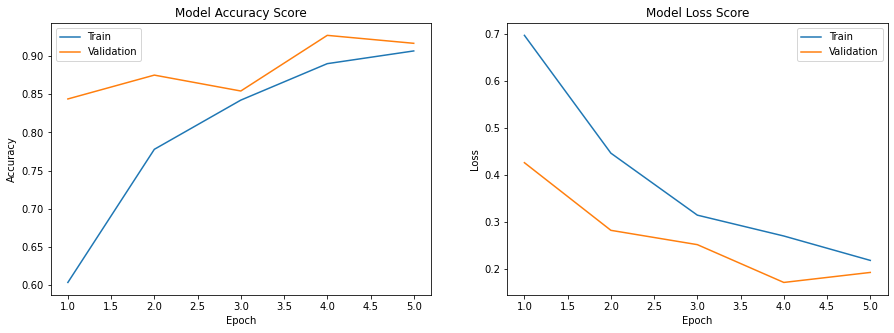

In [110]:
def plot_Trained_model(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy Score')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
    axs[0].legend(['Train', 'Validation'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss Score')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['Train', 'Validation'], loc='best')
    plt.show()
    
plot_model_history(Trained_model)

### Prepare Testing Data

In [111]:
testdata_raw = raw_dataset[10000:10200]

In [112]:
testdata_raw["target"].value_counts()

dog    109
cat     91
Name: target, dtype: int64

In [113]:
testdata = testdata_raw.drop(columns="target")

In [114]:
Y_true = []
for i in testdata_raw["target"]:
    if i == "dog":
        Y_true.append(1)
    else:
        Y_true.append(0)

In [116]:
testdata.head()

,image_path
10000,../working/train/dog.3912.jpg
10001,../working/train/cat.5944.jpg
10002,../working/train/dog.7317.jpg
10003,../working/train/cat.1962.jpg
10004,../working/train/dog.10155.jpg


### Create Testing Generator

In [117]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    testdata,
    #"../input/test1/test1/", 
    x_col='image_path',
    y_col=None,
    class_mode=None,
    batch_size=batch_size,
    target_size=(image_size, image_size),
    shuffle=False
)

Found 200 validated image filenames.


### Predict

In [118]:
filenames = test_generator.filenames
nb_samples = len(filenames)

In [119]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))
threshold = 0.5
testdata['category'] = np.where(predict > threshold, 1,0)

In [120]:
y_pred = testdata['category']

### See predicted result

In [121]:
accuracy_score(Y_true,y_pred)

0.93

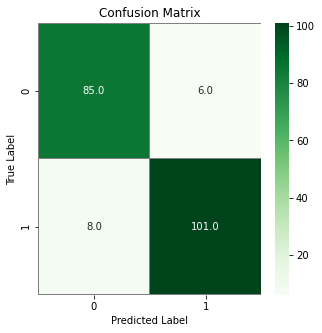

In [122]:

# Predict the values from the validation dataset

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true,y_pred) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(5, 5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()